# Machine Learning Model on NYC Taxi Trip Duration

## Agenda

1. [Dataset Description](#dataset)
2. [Import relevant packages](#package)
3. [Loading the data](#read)
4. [Data Wrangling/Explore the Dataset](#explore)
5. [Descriptive Statistics of the dataset](#describe)
6. [Exploratory Data Analysis(EDA)](#EDA)
    - 6.1. [Data Visualization](#visualize)
    - 6.2. [Feature Engineering](#feature)
7. [Spliting Dataset into Train and Test](#split)
8. [Learning Algorithm Selection](#algo)
    - 8.1 [Building Linear Regression Model](#logreg)
    - 8.2 [Building Decision Tree Regressor Model](#dt)
    - 8.3 [Building Random Forest Regressor Model](#rf)
    - 8.4 [Building AdaBoost Regressor Model](#ab)
    - 8.5 [Building GradientBoosting Regressor Model](#gb)
    - 8.6 [Building XGB Regressor Model](#xgb)
    - 8.7 [Building LGBM Regressor Model](#lgbm)
9. [Model Performance Assessment](#perform)
    - 9.1 [RMSE Score](#perform)
    - 9.2 [R2 Score](#perform)
    - 9.3 [Train and Test Score](#perform)
10. [Model Explanability](#explain)
    - 10.1 [Eli5](#eli5)
    - 10.2 [LIME](#lime)
    - 10.3 [SHAP](#shap)
11. [Closing Remarks](#close)

## 1. Dataset Description <a id='dataset'>

<p/>
The data set contains the data regarding several taxi trips and its duration in New York City. I will now try and apply different techniques of Data Analysis to get insights about the data and determine how different variables are dependent on the target variable Trip Duration.My objective is to build a model that predicts the total trip duration of taxi trips in New York City.


<p/>
<b>File Descriptions:</b>
<br/>
<b>taxi_train.csv</b> - the training set (contains 1458644 trip records)

<p/>
<b>Data Fields:</b>
<br/>
<b>id</b> - a unique identifier for each trip.<br/>
<b>vendor_id</b> - a code indicating the provider associated with the trip record <br/>
<b>pickup_datetime</b> - date and time when the meter was engaged. <br/>
<b>dropoff_datetime</b> - date and time when the meter was disengaged.<br/>
<b>passenger_count</b> - the number of passengers in the vehicle (driver entered value). <br/>
<b>pickup_longitude</b> - the longitude where the meter was engaged. <br/>
<b>pickup_latitude</b> - the latitude where the meter was engaged. <br/>
<b>dropoff_longitude</b> - the longitude where the meter was disengaged. <br/>
<b>dropoff_latitude</b> - the latitude where the meter was disengaged.<br/>
<b>store_and_fwd_flag</b> - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.<br/>
<b>trip_duration</b> - duration of the trip in seconds.<br/>

## 2. Import relevent packages <a id='package'>

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly_express as px
import time
import random 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from vecstack import stacking
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import eli5
from eli5.sklearn import PermutationImportance
import lime
import lime.lime_tabular
import shap
import geopandas as gpd
from shapely.geometry import Point,Polygon
import descartes

C:\Users\pc\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\pc\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## 3. Loading the data <a id='read'>

We'll be working with a dataset that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview)).

#### Through Dask

In [2]:
#Read data through Dask and compute time taken to read
t_start = time.time()
df_taxi = dd.read_csv('taxi_train.csv')
t_end = time.time()
print('dd.read_csv(): {} s'.format(t_end-t_start)) # time [s]

dd.read_csv(): 0.4050002098083496 s


#### Through Pandas

In [3]:
#Read data through Pandas and compute time taken to read
t_start = time.time()
df_taxi = pd.read_csv('taxi_train.csv',parse_dates=['pickup_datetime','dropoff_datetime'],infer_datetime_format=True)
t_end = time.time()
print('pd.read_csv(): {} s'.format(t_end-t_start)) # time [s]

pd.read_csv(): 22.904200077056885 s


## 4. Data Wrangling/Explore the Dataset <a id='explore'>

In [4]:
#Getting the head of the dataset
df_taxi.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
#Shape of the dataset
df_taxi.shape

(1458644, 11)

**We have 1458644 observations, 11 features, and our target variable is trip_duration**

In [6]:
#Data Type of features for dataset
df_taxi.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

In [7]:
#Info of the dataset
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [8]:
#Checking for null values in dataset
df_taxi.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

**Great!No missing values in the dataset.**

In [9]:
#Checking duplicate value in vendor_id
df_taxi[df_taxi.duplicated(['id'], keep=False)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


**No duplicastes available in id which is trip id!**

In [10]:
#Checking Date and Time range
print('Datetime range: {} to {}'.format(df_taxi.pickup_datetime.min(),df_taxi.dropoff_datetime.max()))

Datetime range: 2016-01-01 00:00:17 to 2016-07-01 23:02:03


**Data is of 6 full months, from January 2016 to June 2016!**

In [11]:
#Checking no. of vendors
df_taxi['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [12]:
#Checking Passenger count
print('Passenger Count: {} to {}'.format(df_taxi.passenger_count.min(),df_taxi.passenger_count.max()))

Passenger Count: 0 to 9


In [13]:
#The distribution of Pickup and Drop Off day of the week
print(df_taxi['pickup_datetime'].nunique())
print(df_taxi['dropoff_datetime'].nunique())

1380222
1380377


**There are many different pickup and drop off dates in these 2 columns.**

In [14]:
#Performing Pandas profiling to understand quick overview of columns
report = pandas_profiling.ProfileReport(df_taxi)
#coverting profile report as html file
report.to_file('taxi_train.html')

from IPython.display import display,HTML,IFrame
display(HTML(open('taxi_train.html').read()))  

Number of variables,11
Number of observations,1458644
Total Missing (%),0.0%
Total size in memory,122.4 MiB
Average record size in memory,88.0 B
Numeric,6
Categorical,1
Boolean,1
Date,2
Text (Unique),1
Rejected,0


## 5. Descriptive Statistics of the dataset <a id='describe'> 

In [15]:
#Summary statistics for the dataset
df_taxi.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


## 6. Exploratory Data Analysis(EDA) <a id='EDA'> 

### Feature Engineering & Data Visualization<a id='feature'>

#### Lets have a look at the distribution of various variables in the Data set.

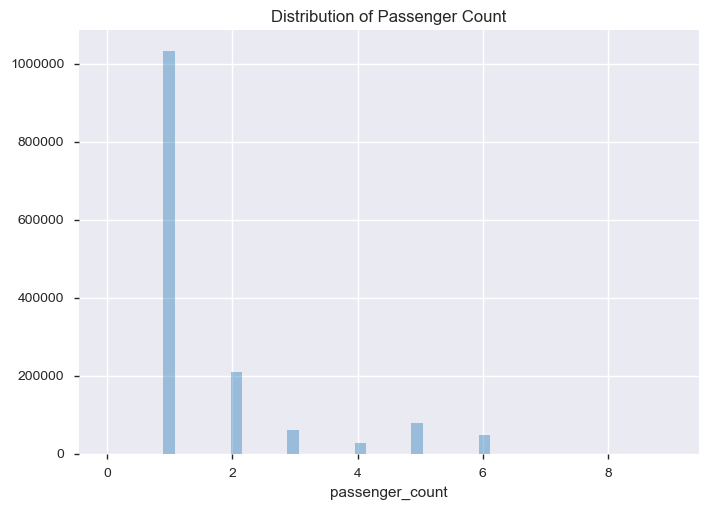

In [16]:
#Passenger Count
sns.distplot(df_taxi['passenger_count'],kde=False)
plt.title('Distribution of Passenger Count')
plt.show()

**Here we can see that mostly 1 or 2 passengers avail the taxi. The instance of large group of people travelling together is rare.**

#### Lets create some features from datetime stamp. 

In [17]:
#Creating pickup and dropoff day
df_taxi['pickup_day']=df_taxi['pickup_datetime'].dt.day_name()
df_taxi['dropoff_day']=df_taxi['dropoff_datetime'].dt.day_name()

In [18]:
#Creating pickup and dropoff month
df_taxi['pickup_month']=df_taxi['pickup_datetime'].dt.month
df_taxi['dropoff_month']=df_taxi['dropoff_datetime'].dt.month

In [19]:
#Creating pickup and dropoff hour
df_taxi['pickup_hour']=df_taxi['pickup_datetime'].dt.hour
df_taxi['dropoff_hour']=df_taxi['dropoff_datetime'].dt.hour

In [20]:
df_taxi.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_hour,dropoff_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,3,3,17,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,6,0,0


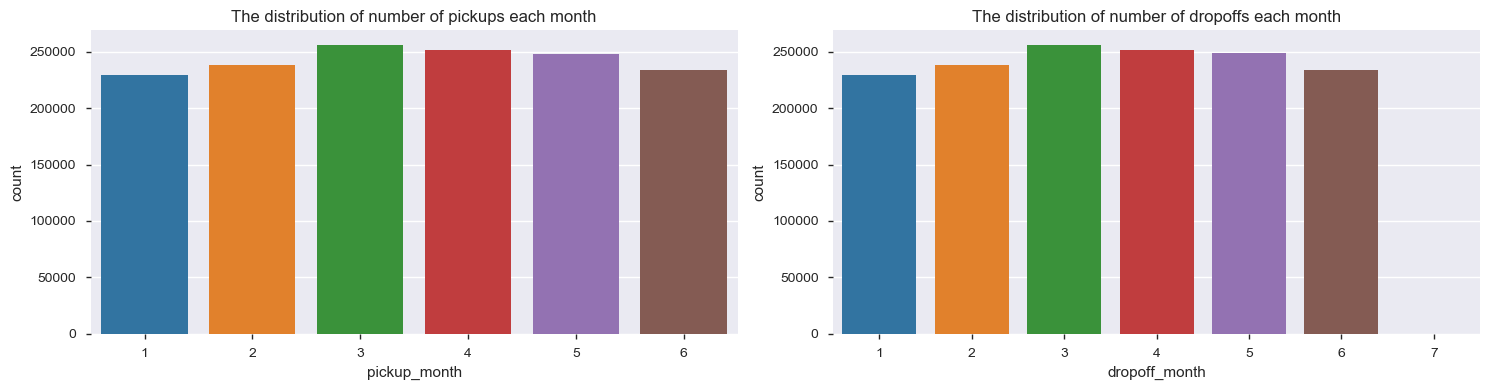

In [21]:
#Plotting monthly Pickup and Dropoff trip distribution
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,4))
sns.countplot(x='pickup_month',data=df_taxi,ax=ax[0])
ax[0].set_title('The distribution of number of pickups each month')
sns.countplot(x='dropoff_month',data=df_taxi,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs each month')
plt.tight_layout()

**There is not so much of difference in Pickup and dropoff month.**

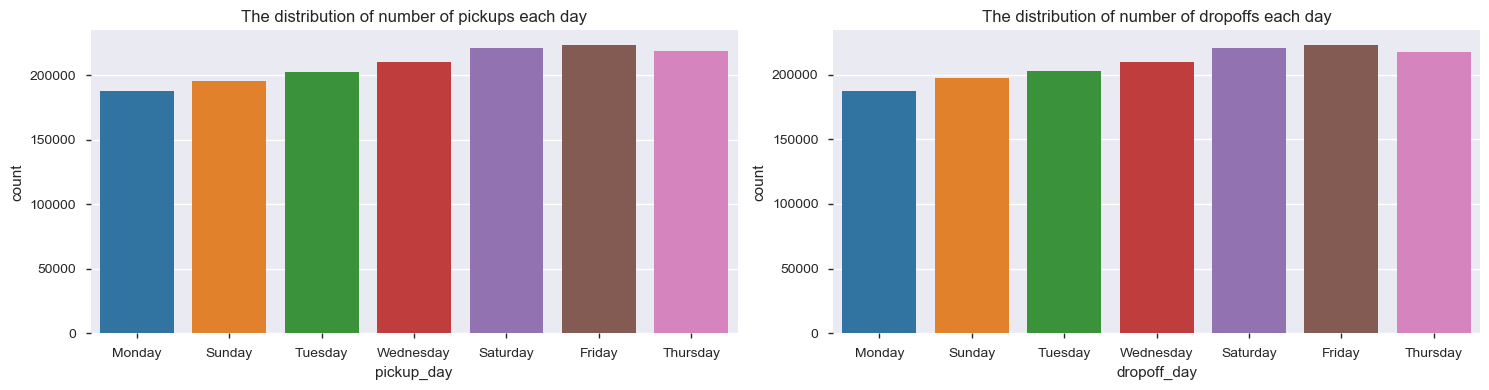

In [22]:
#Plotting daily Pickup and Dropoff trip distribution
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,4))
sns.countplot(x='pickup_day',data=df_taxi,ax=ax[0])
ax[0].set_title('The distribution of number of pickups each day')
sns.countplot(x='dropoff_day',data=df_taxi,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs each day')
plt.tight_layout()

**We can see most trips were taken on Friday & least trips were taken on Monday.**

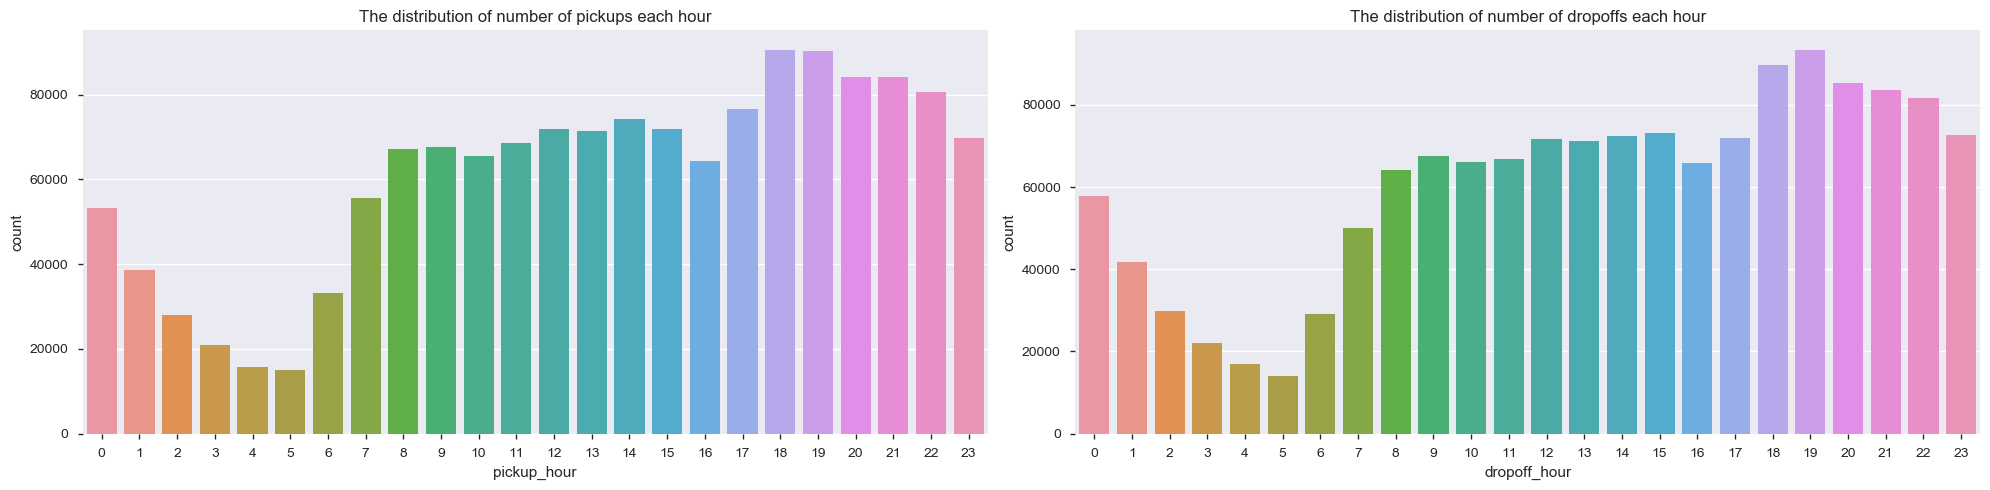

In [23]:
#Plotting hourly Pickup and Dropoff trip distribution
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.countplot(x='pickup_hour',data=df_taxi,ax=ax[0])
ax[0].set_title('The distribution of number of pickups each hour')
sns.countplot(x='dropoff_hour',data=df_taxi,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs each hour')
plt.tight_layout()

**Both the distribution looks quite similiar,majority of the trip has been booked from 6PM to 22PM.**

In [24]:
#Creating a new column according to the traffic scenerio of New York
def rush_hour(hour):
    if hour.item()>=7 and hour.item()<=9:
        return 'rush_hour_morning(7-9)'
    elif hour.item()>9 and hour.item()<16:
        return 'normal_hour_afternoon(9-16)'
    elif hour.item()>=16 and hour.item()<=19:
        return 'rush_hour_evening(16-19)'
    elif hour.item()>19 and hour.item()<=23:
        return 'normal_hour_evining(19-23)'
    else:
        return 'latenight(23 onwards)'
df_taxi['traffic_scenerio_pickup']=df_taxi[['pickup_hour']].apply(rush_hour, axis=1)
df_taxi['traffic_scenerio_dropoff']=df_taxi[['dropoff_hour']].apply(rush_hour, axis=1)

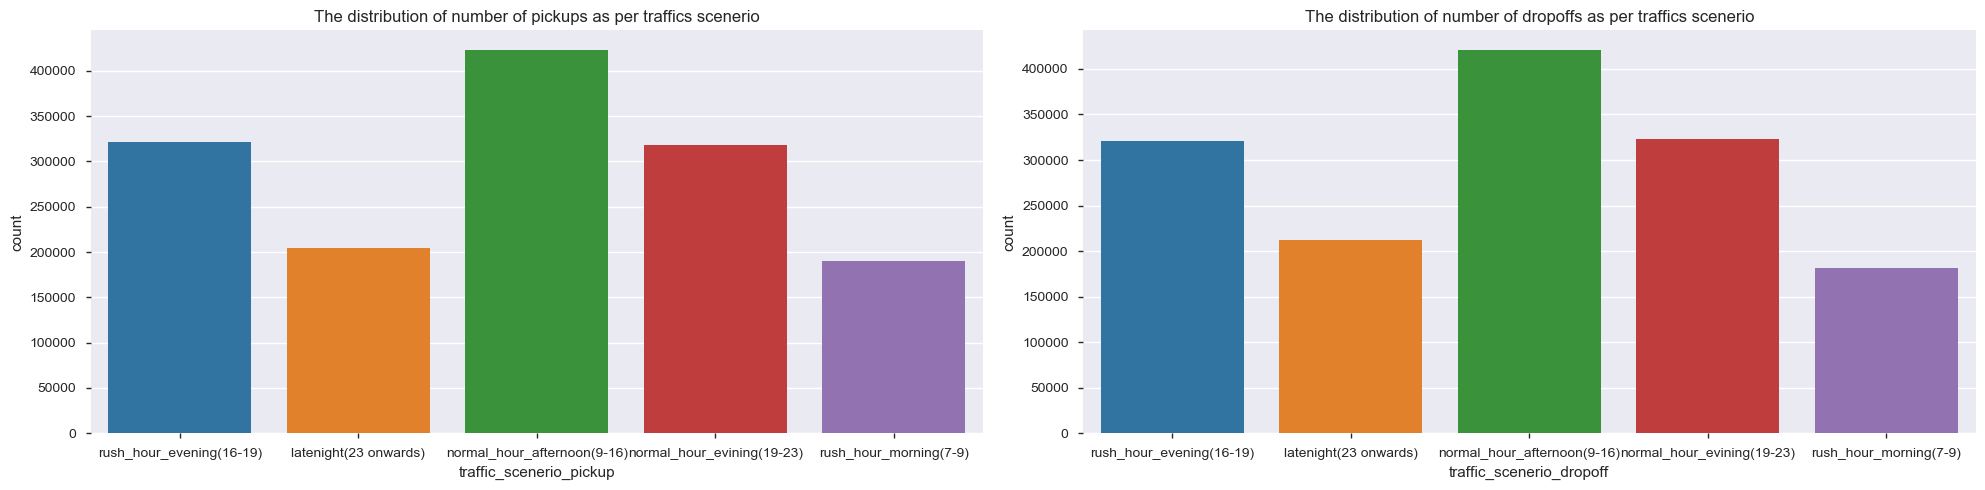

In [25]:
#Plotting pickup and dropoff trip distribution as per traffic scenerio
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.countplot(x='traffic_scenerio_pickup',data=df_taxi,ax=ax[0])
ax[0].set_title('The distribution of number of pickups as per traffics scenerio')
sns.countplot(x='traffic_scenerio_dropoff',data=df_taxi,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs as per traffics scenerio')
plt.tight_layout()

#### Distribution of the trip duration

Text(0.5, 1.0, 'The distribution of of the Pick Up  Duration distribution')

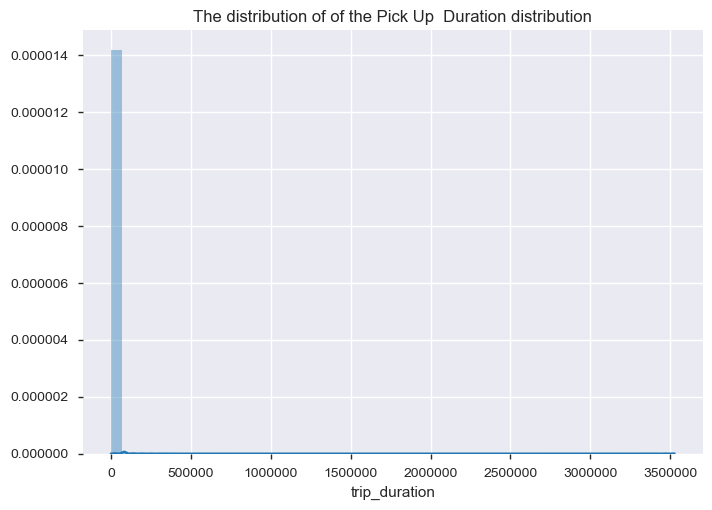

In [26]:
sns.distplot(df_taxi['trip_duration'],kde=True)
plt.title('The distribution of of the Pick Up  Duration distribution')

**This histogram shows extreme right skewness, hence there are outliers. Lets see the boxplot of this variable.**

Text(0.5, 1.0, 'A boxplot depicting the pickup duration distribution')

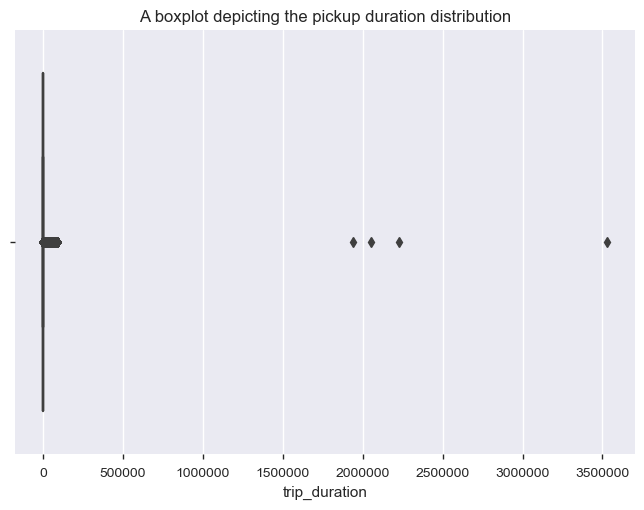

In [27]:
sns.boxplot(df_taxi['trip_duration'], orient='horizontal')
plt.title('A boxplot depicting the pickup duration distribution')

**We can see there are few outliers, which we have to treat.**

In [28]:
#Dropping trip_duration <1 min
df_taxi= df_taxi[df_taxi.trip_duration>60] # >1 min

In [29]:
#Dropping trip_duration >2 Hrs
df_taxi= df_taxi[df_taxi.trip_duration<=7200] # >2 hrs

**Removed trip duration of less than 1 min and greater than 2 hrs as its not looking sensible that one can hire taxi for less than a min or more that 2 hrs in a city like New York!**

#### Distribution of vendor_id

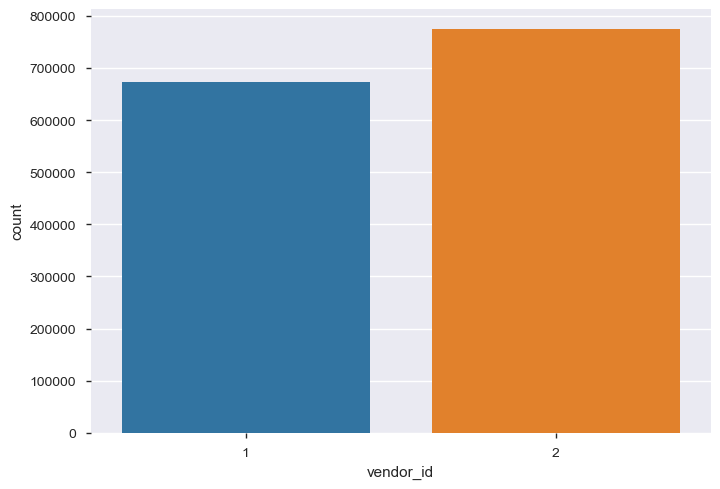

In [30]:
sns.countplot(x='vendor_id',data=df_taxi)

**The distribution of vendor id is not much different.**

#### Analysing geographical boundary of NYC.

In [31]:
#Checking Longitude and Lattitude bounds available in the data
print('Longitude Bounds: {} to {}'.format(max(df_taxi.pickup_longitude.min(),df_taxi.dropoff_longitude.min()),max(df_taxi.pickup_longitude.max(),df_taxi.dropoff_longitude.max())))
print('Lattitude Bounds: {} to {}'.format(max(df_taxi.pickup_latitude.min(),df_taxi.dropoff_latitude.min()),max(df_taxi.pickup_latitude.max(),df_taxi.dropoff_latitude.max())))

Longitude Bounds: -121.9333038330078 to -61.33552932739258
Lattitude Bounds: 34.359695434570305 to 51.88108444213867


In [32]:
#The borders of NY City, in coordinates comes out to be: city_long_border = (-74.03, -73.75) & city_lat_border = (40.63, 40.85)
#Comparing this to our 'df_taxi.describe()' output we see that there are some coordinate points (pick ups/drop offs) that fall outside these borders. So let's limit our area of investigation to within the NY City borders.
df_taxi = df_taxi[df_taxi['pickup_longitude'] <= -73.75]
df_taxi = df_taxi[df_taxi['pickup_longitude'] >= -74.03]
df_taxi = df_taxi[df_taxi['pickup_latitude'] <= 40.85]
df_taxi = df_taxi[df_taxi['pickup_latitude'] >= 40.63]
df_taxi = df_taxi[df_taxi['dropoff_longitude'] <= -73.75]
df_taxi = df_taxi[df_taxi['dropoff_longitude'] >= -74.03]
df_taxi = df_taxi[df_taxi['dropoff_latitude'] <= 40.85]
df_taxi = df_taxi[df_taxi['dropoff_latitude'] >= 40.63]

**Limited the New York City boundary as per City Long and Lat Boundary!**

In [33]:
#Getting distance(in km) from geographocal co-ordinates
from math import radians, sin, cos, sqrt, asin
def haversine(columns):
    lat1, lon1, lat2, lon2 = columns
    R = 6372.8 # Earth radius in kilometers
    
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    
    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))
    
    return R * c

cols = ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
distances = df_taxi[cols].apply(lambda x: haversine(x),axis = 1)
df_taxi['distance_km'] = distances.copy()
df_taxi['distance_km'] = round(df_taxi.distance_km,2)

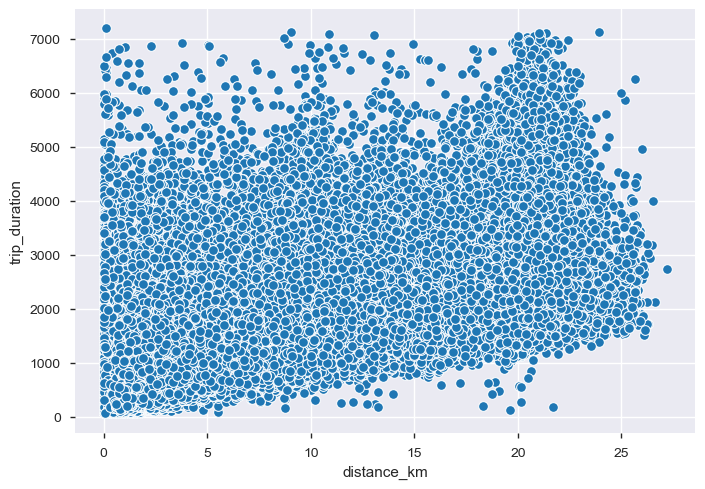

In [34]:
sns.scatterplot(x='distance_km',y='trip_duration',data=df_taxi)

In [35]:
#Removing distance Outliers
df_taxi = df_taxi[df_taxi['distance_km'] > 0]

**Removed distance which have 0 value,seems to be cancelled trips.**

In [36]:
#Getting Speed(Km/h) of the taxi 
df_taxi['speed_km/h']= 3600*(df_taxi.distance_km/df_taxi.trip_duration)  #3600 to convert it from km/s to km/h

In [37]:
#Checking Distance and Speed range
print('Distance Bounds: {} to {}'.format(df_taxi.distance_km.min(),df_taxi.distance_km.max()))
print('Speed Bounds: {} to {}'.format(df_taxi['speed_km/h'].min(),df_taxi['speed_km/h'].max()))

Distance Bounds: 0.01 to 27.2
Speed Bounds: 0.005539313740575473 to 584.0330578512397


In [38]:
#Removing speed Outliers
df_taxi = df_taxi[df_taxi['speed_km/h'] > 0]
df_taxi = df_taxi[df_taxi['speed_km/h'] < 100]

**Removed average speed equals to zero and more than 100, as its seems to be outliers.**

In [39]:
#Dropping passenger count=0
df_taxi= df_taxi[df_taxi.passenger_count>0]
df_taxi['passenger_count'].value_counts()

1    1009190
2     205377
5      76365
3      58594
6      47222
4      27730
Name: passenger_count, dtype: int64

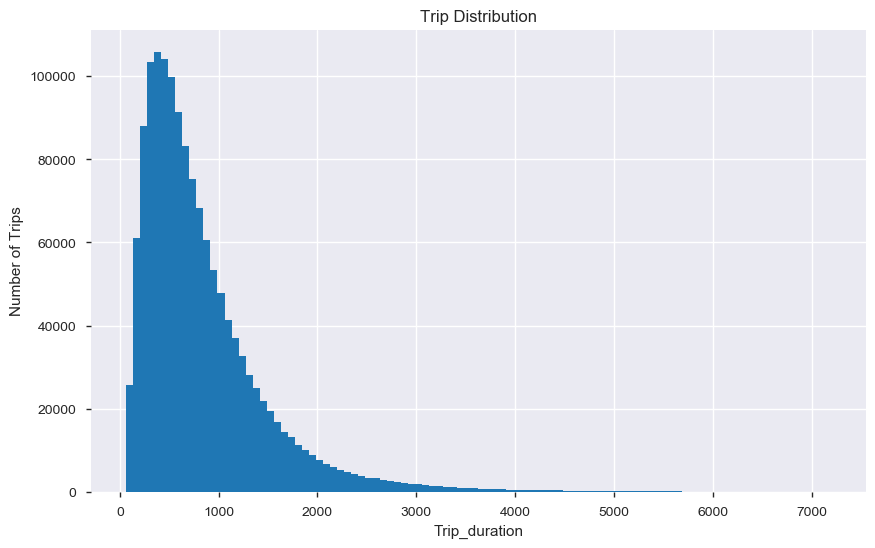

In [40]:
#Plotting Trip Distribution
plt.figure(figsize=(10,6))
plt.hist(df_taxi.trip_duration, bins=100)
plt.xlabel('Trip_duration')
plt.ylabel('Number of Trips')
plt.title('Trip Distribution')
plt.show()

**Seems the distribution is skewed so we can apply certain transforms such as log transform!**

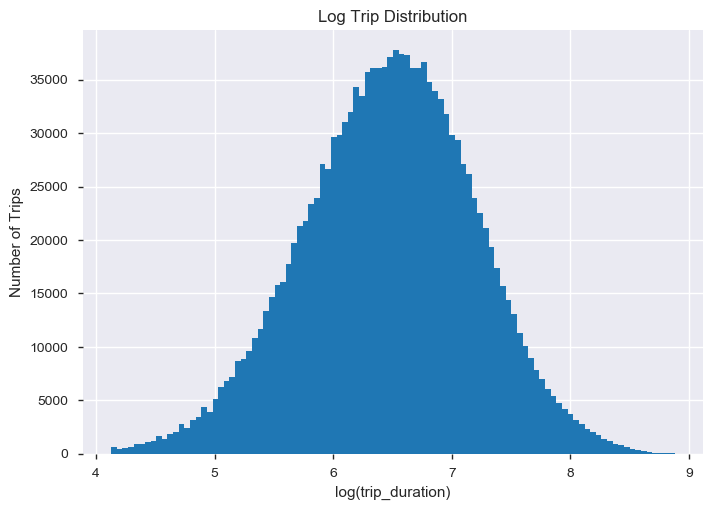

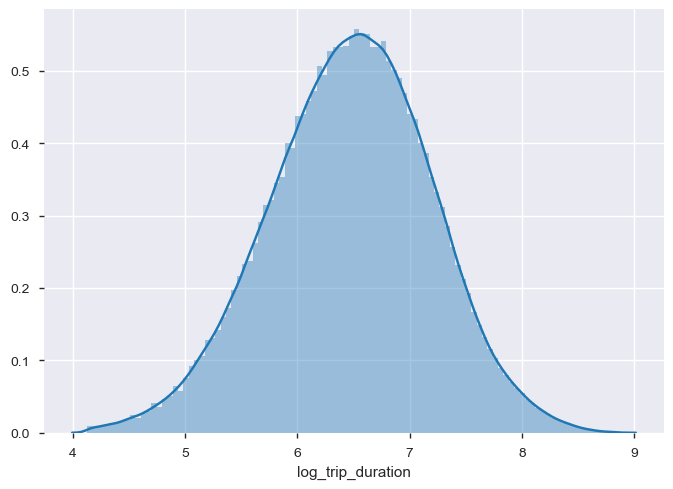

In [41]:
#Applying Feature Scaling in trip_duration caloumn to normalize the data
df_taxi['log_trip_duration']= np.log1p(df_taxi['trip_duration'])
plt.hist(df_taxi['log_trip_duration'].values, bins=100)
plt.title('Log Trip Distribution')
plt.xlabel('log(trip_duration)')
plt.ylabel('Number of Trips')
plt.show()
sns.distplot(df_taxi["log_trip_duration"], bins =100)

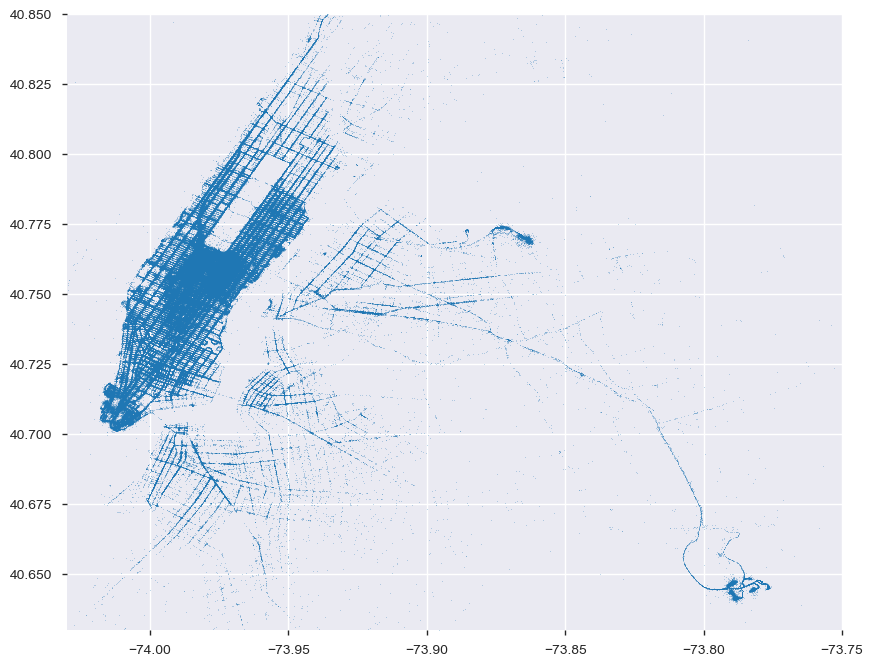

In [42]:
#Visualizing Passenger road map for picking up
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
plt.ylim(40.63, 40.85)
plt.xlim(-74.03,-73.75)
ax.scatter(df_taxi['pickup_longitude'],df_taxi['pickup_latitude'], s=0.02, alpha=1)

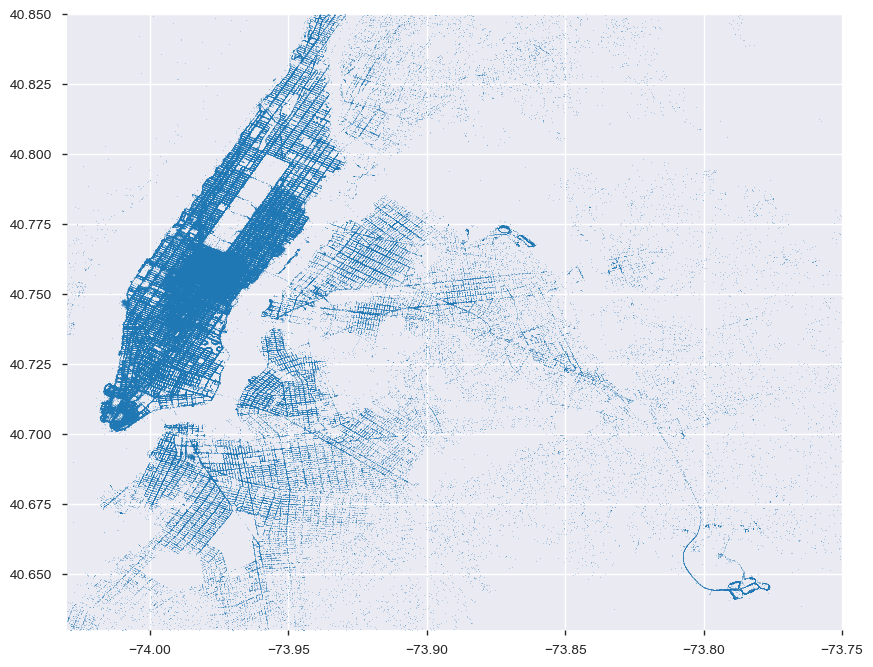

In [43]:
#Visualizing Passenger road map for dropoff
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,8))
plt.ylim(40.63, 40.85)
plt.xlim(-74.03,-73.75)
ax.scatter(df_taxi['dropoff_longitude'],df_taxi['dropoff_latitude'], s=0.02, alpha=1)

In [44]:
#Converting Data to Geo Dataframe for pickup 
gdf=gpd.GeoDataFrame(df_taxi,geometry=gpd.points_from_xy(df_taxi['pickup_longitude'],df_taxi['pickup_latitude']))

In [45]:
#Geometry point has been generated for pickup
gdf.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_month,dropoff_month,pickup_hour,dropoff_hour,traffic_scenerio_pickup,traffic_scenerio_dropoff,distance_km,speed_km/h,log_trip_duration,geometry
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,3,3,17,17,rush_hour_evening(16-19),rush_hour_evening(16-19),1.50,11.868132,6.122493,POINT (-73.98215 40.76794)
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6,6,0,0,latenight(23 onwards),latenight(23 onwards),1.81,9.828054,6.498282,POINT (-73.98042 40.73856)


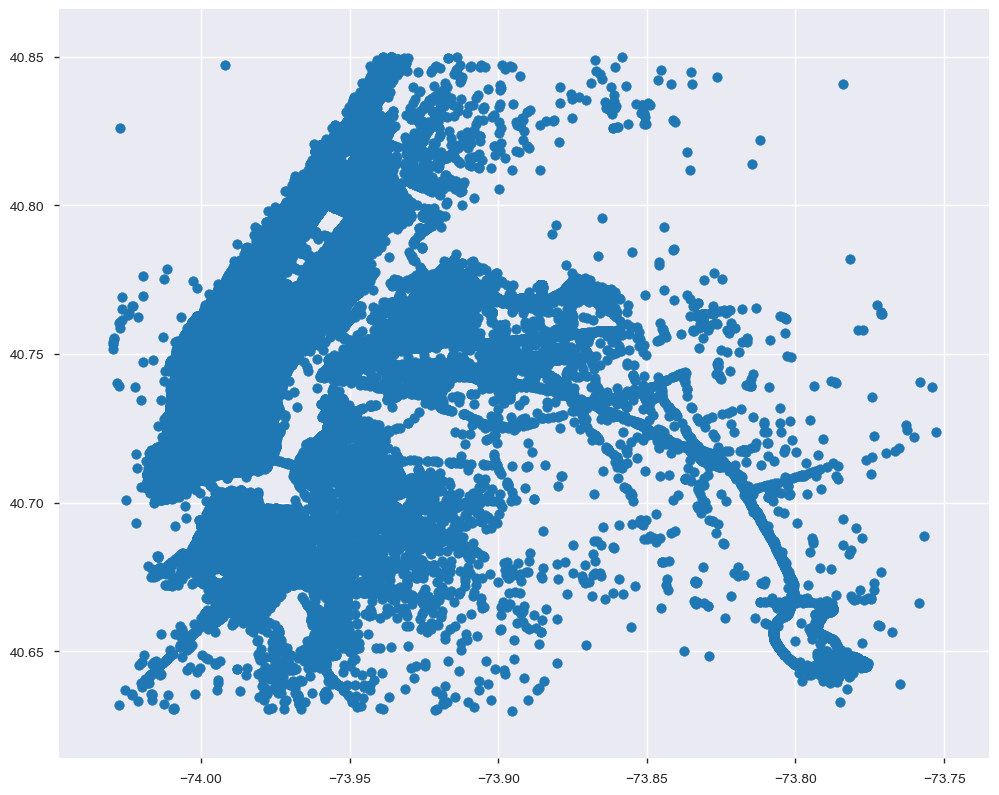

In [46]:
#Visulizing pickup points with geopandas
gdf.plot(figsize=(12,10))

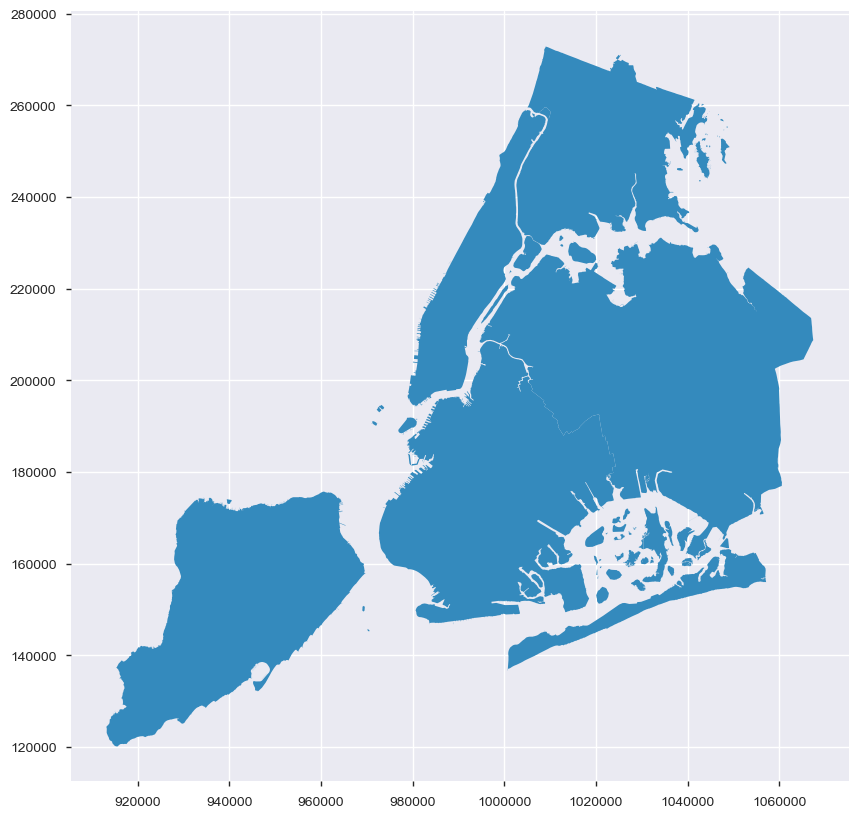

In [47]:
#Getting New York City map from Geopandas
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
ax = nyc.plot(figsize=(12, 10))

**We can overlap datapoints to the map for getting better idea!**

##### Categorical Encoding - One Hot Encoding

In [48]:
#Applying one hot encoding to the catagorical variables
taxi_vendor=pd.get_dummies(df_taxi['vendor_id'], prefix='vendor_id',drop_first= True)
taxi_pax=pd.get_dummies(df_taxi['passenger_count'], prefix='passenger',drop_first= True)
taxi_store_and_fwd_flag=pd.get_dummies(df_taxi['store_and_fwd_flag'], prefix='store_and_fwd_flag',drop_first= True)
taxi_pickup_day=pd.get_dummies(df_taxi['pickup_day'], prefix='pickup_day',drop_first= True)
taxi_dropoff_day=pd.get_dummies(df_taxi['dropoff_day'], prefix='dropoff_day',drop_first= True)
taxi_pickup_month=pd.get_dummies(df_taxi['pickup_month'], prefix='pickup_month',drop_first= True)
taxi_dropoff_month=pd.get_dummies(df_taxi['dropoff_month'], prefix='dropoff_month',drop_first= True)
taxi_pickup_traffic_scenerio=pd.get_dummies(df_taxi['traffic_scenerio_pickup'], prefix='pickup_',drop_first= True)
taxi_dropoff_traffic_scenerio=pd.get_dummies(df_taxi['traffic_scenerio_dropoff'], prefix='dropoff_',drop_first= True)

In [49]:
#Adding encoded columns to final data
df_taxi=pd.concat([df_taxi,taxi_pax,taxi_vendor,taxi_store_and_fwd_flag,taxi_pickup_day,taxi_dropoff_day,taxi_pickup_month,taxi_dropoff_month,taxi_pickup_traffic_scenerio,taxi_dropoff_traffic_scenerio],axis=1)

In [50]:
df_taxi.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_month_6,dropoff_month_7,pickup__normal_hour_afternoon(9-16),pickup__normal_hour_evining(19-23),pickup__rush_hour_evening(16-19),pickup__rush_hour_morning(7-9),dropoff__normal_hour_afternoon(9-16),dropoff__normal_hour_evining(19-23),dropoff__rush_hour_evening(16-19),dropoff__rush_hour_morning(7-9)
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,0,0,0,1,0,0,0,1,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,1,0,0,0,0,0,0,0,0,0


In [51]:
#Dropping unnecessary columns from dataset
df_taxi=df_taxi.drop(['id','vendor_id','passenger_count','pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','log_trip_duration','speed_km/h','store_and_fwd_flag','traffic_scenerio_pickup','traffic_scenerio_dropoff','pickup_month','dropoff_month','pickup_day','dropoff_day','pickup_hour','dropoff_hour','geometry','dropoff_month_7'],axis=1)

In [52]:
df_taxi.columns

Index(['trip_duration', 'distance_km', 'passenger_2', 'passenger_3',
       'passenger_4', 'passenger_5', 'passenger_6', 'vendor_id_2',
       'store_and_fwd_flag_Y', 'pickup_day_Monday', 'pickup_day_Saturday',
       'pickup_day_Sunday', 'pickup_day_Thursday', 'pickup_day_Tuesday',
       'pickup_day_Wednesday', 'dropoff_day_Monday', 'dropoff_day_Saturday',
       'dropoff_day_Sunday', 'dropoff_day_Thursday', 'dropoff_day_Tuesday',
       'dropoff_day_Wednesday', 'pickup_month_2', 'pickup_month_3',
       'pickup_month_4', 'pickup_month_5', 'pickup_month_6', 'dropoff_month_2',
       'dropoff_month_3', 'dropoff_month_4', 'dropoff_month_5',
       'dropoff_month_6', 'pickup__normal_hour_afternoon(9-16)',
       'pickup__normal_hour_evining(19-23)',
       'pickup__rush_hour_evening(16-19)', 'pickup__rush_hour_morning(7-9)',
       'dropoff__normal_hour_afternoon(9-16)',
       'dropoff__normal_hour_evining(19-23)',
       'dropoff__rush_hour_evening(16-19)', 'dropoff__rush_hour_morning

## 7. Spliting Dataset into Train and Test <a id='split'> 

In [53]:
#Assigning X and y variables
X = df_taxi.drop('trip_duration',1)
y = df_taxi['trip_duration']

In [54]:
#Splitting the dataset into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

## 8. Learning Algorithm Selection<a id='algo'> 

### 8.1. Building Linear Regression Model <a id='logreg'>

In [55]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

In [56]:
#RMSE score 
lr_rmse = np.sqrt(metrics.mean_squared_error(lr_pred,y_test))
lr_rmse

385.34727896445276

In [57]:
#R2 score
lr_r2score = metrics.r2_score(lr_pred,y_test)
lr_r2score

0.4283958890553893

In [58]:
#Train Score
lr_train=lr.score(X_train,y_train)
lr_train

0.6372581055161197

In [59]:
#Test Score
lr_test=lr.score(X_test,y_test)
lr_test

0.6361417244238469

In [60]:
#Null RMSE
y_null=np.zeros_like(y_test,dtype=float)
y_null.fill(y_test.mean())
np.sqrt(metrics.mean_squared_error(y_test,y_null))

638.8312729898362

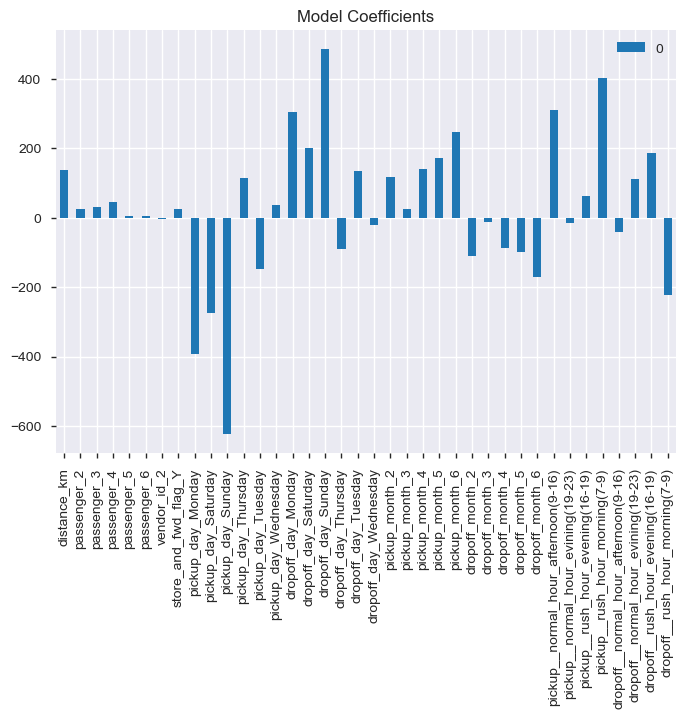

In [61]:
coef1 = pd.DataFrame(lr.coef_,index=X_train.columns)
coef1.plot(kind='bar', title='Model Coefficients')

**We can see that the regression model with all the columns performed well except few columns.**

### 8.2. Building Decision Tree Regressor Model <a id='dt'>

In [62]:
dt=DecisionTreeRegressor()
dt.fit(X_train,y_train)
dt_pred=dt.predict(X_test)

In [63]:
#RMSE score 
dt_rmse = np.sqrt(metrics.mean_squared_error(dt_pred,y_test))
dt_rmse

453.49603544446137

In [64]:
#R2 score
dt_r2score = metrics.r2_score(dt_pred,y_test)
dt_r2score

0.47616862951824135

In [65]:
#Train Score
dt_train=dt.score(X_train,y_train)
dt_train

0.9095794957255137

In [66]:
#Test Score
dt_test=dt.score(X_test,y_test)
dt_test

0.49606484867086775

### 8.3. Building Random Forest Regressor Model <a id='rf'>

In [67]:
rf=RandomForestRegressor()
rf.fit(X_train,y_train)
rf_pred=rf.predict(X_test)

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [68]:
#RMSE score 
rf_rmse = np.sqrt(metrics.mean_squared_error(rf_pred,y_test))
rf_rmse

386.9396361745182

In [69]:
#R2 score
rf_r2score = metrics.r2_score(rf_pred,y_test)
rf_r2score

0.5510780117297178

In [70]:
#Train Score
rf_train=rf.score(X_train,y_train)
rf_train

0.8721169562291995

In [71]:
#Test Score
rf_test=rf.score(X_test,y_test)
rf_test

0.6331283934275569

### 8.4. Building AdaBoost Regressor Model <a id='ab'>

In [72]:
ab=AdaBoostRegressor()
ab.fit(X_train,y_train)
ab_pred=ab.predict(X_test)

In [73]:
#RMSE score 
ab_rmse = np.sqrt(metrics.mean_squared_error(ab_pred,y_test))
ab_rmse

566.8817594816671

In [74]:
#R2 score
ab_r2score = metrics.r2_score(ab_pred,y_test)
ab_r2score

-0.0409466898192854

In [75]:
#Train Score
ab_train=ab.score(X_train,y_train)
ab_train

0.213935076784568

In [76]:
#Test Score
ab_test=ab.score(X_test,y_test)
ab_test

0.2125687802838876

### 8.5. Building GradientBoosting Regressor Model <a id='gb'>

In [77]:
gb = GradientBoostingRegressor()
gb.fit(X_train,y_train)
gb_pred = gb.predict(X_test)

In [78]:
#RMSE score 
gb_rmse = np.sqrt(metrics.mean_squared_error(gb_pred,y_test))
gb_rmse

349.1955977013773

In [79]:
#R2 score
gb_r2score = metrics.r2_score(gb_pred,y_test)
gb_r2score

0.5548472087460741

In [80]:
#Train Score
gb_train=gb.score(X_train,y_train)
gb_train

0.7031059615820991

In [81]:
#Test Score
gb_test=gb.score(X_test,y_test)
gb_test

0.7012106018605775

### 8.6. Building XGB Regressor Model <a id='xgb'>

In [82]:
xgb= XGBRegressor()
xgb.fit(X_train,y_train)
xgb_pred=xgb.predict(X_test)

In [83]:
#RMSE score 
xgb_rmse = np.sqrt(metrics.mean_squared_error(xgb_pred,y_test))
xgb_rmse

339.1045889249467

In [84]:
#R2 score
xgb_r2score = metrics.r2_score(xgb_pred,y_test)
xgb_r2score

0.6092681318918447

In [85]:
#Train Score
xgb_train=xgb.score(X_train,y_train)
xgb_train

0.7279757554958409

In [86]:
#Test Score
xgb_test=xgb.score(X_test,y_test)
xgb_test

0.7182298407709367

### 8.7. Building LGBM Regressor Model <a id='lgbm'>

In [87]:
lgbm = lgb.LGBMRegressor()
lgbm.fit(X_train,y_train)
lgbm_pred = lgbm.predict(X_test)

In [88]:
#RMSE score 
lgbm_rmse = np.sqrt(metrics.mean_squared_error(lgbm_pred,y_test))
lgbm_rmse

339.17050674286855

In [89]:
#R2 score
lgbm_r2score = metrics.r2_score(lgbm_pred,y_test)
lgbm_r2score

0.6039406722715048

In [90]:
#Train Score
lgbm_train=lgbm.score(X_train,y_train)
lgbm_train

0.7207316443681338

In [91]:
#Test Score
lgbm_test=lgbm.score(X_test,y_test)
lgbm_test

0.7181202847229976

## 9. Model Performance Assessment <a id='perform'> 

In [92]:
#Creating dictionary for all the metrics and models
metrics = {'Metrics': ['RMSE Score','R2 Score','Train Score','Test Score'],'Linear Regression':[lr_rmse,lr_r2score,lr_train,lr_test],
          'Decision Tree Regressor':[dt_rmse,dt_r2score,dt_train,dt_test],'Random Forest Regressor':[rf_rmse,rf_r2score,rf_train,rf_test],
        'AdaBoost Regressor':[ab_rmse,ab_r2score,ab_train,ab_test],
          'GradientBoosting Regressor':[gb_rmse,gb_r2score,gb_train,gb_test],'XGBoost Regressor':[xgb_rmse,xgb_r2score,xgb_train,xgb_test],
           'LGBM Regressor':[lgbm_rmse,lgbm_r2score,lgbm_train,lgbm_test]}

In [93]:
#Converting dictionary to dataframe
metrics = pd.DataFrame(metrics)
metrics

,Metrics,Linear Regression,Decision Tree Regressor,Random Forest Regressor,AdaBoost Regressor,GradientBoosting Regressor,XGBoost Regressor,LGBM Regressor
0,RMSE Score,385.347279,453.496035,386.939636,566.881759,349.195598,339.104589,339.170507
1,R2 Score,0.428396,0.476169,0.551078,-0.040947,0.554847,0.609268,0.603941
2,Train Score,0.637258,0.909579,0.872117,0.213935,0.703106,0.727976,0.720732
3,Test Score,0.636142,0.496065,0.633128,0.212569,0.701211,0.718230,0.718120


**Looking at the above Performance Matrix we can say thay XGBoost is the best model for this dataset.We may perform hyperparameter tuning on XGBoost model to improve the performance of the model**

## 10. Model Explanability <a id='explain'> 

### 10.1. Eli5<a id='eli5'>

In [94]:
#Finding the importance of columns for prediction
perm = PermutationImportance(xgb, random_state=1).fit(X_test,xgb_pred)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
1.8970 ± 0.0077,distance_km
0.0839 ± 0.0017,dropoff__rush_hour_evening(16-19)
0.0700 ± 0.0006,dropoff__normal_hour_afternoon(9-16)
0.0395 ± 0.0008,pickup_day_Sunday
0.0308 ± 0.0004,pickup__rush_hour_morning(7-9)
0.0306 ± 0.0003,pickup__normal_hour_afternoon(9-16)
0.0237 ± 0.0003,pickup_day_Saturday
0.0195 ± 0.0002,pickup_month_6
0.0182 ± 0.0001,pickup__rush_hour_evening(16-19)
0.0161 ± 0.0003,pickup__normal_hour_evining(19-23)


## 11. Closing Remarks <a id='close'> 

**In this project we covered various aspects of the Machine learning development cycle. We observed that the data exploration and variable analysis is a very important aspect of the whole cycle and should be done for thorough understanding of the data. We also cleaned the data while exploring as there were some outliers which should be treated before feature engineering. Further we did feature engineering to filter and gather only the optimal features which are more significant and covered most of the variance in the dataset. Then finally we trained the models on the optimum featureset to get the results.**